In [1]:
import numpy as np
import csv

In [2]:
labels = []

with open("images/faceLabels.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        labels.append(row)
labels = np.array(labels[1:])

labels

array([['face1.png', 'Neutral'],
       ['face2.png', 'Neutral'],
       ['face3.png', 'Neutral'],
       ['face4.png', 'Neutral'],
       ['face5.png', 'Neutral'],
       ['face6.png', 'Neutral'],
       ['face7.png', 'Neutral'],
       ['face8.png', 'Neutral'],
       ['face9.png', 'Neutral'],
       ['face10.png', 'Neutral'],
       ['face11.png', 'Neutral'],
       ['face12.png', 'Neutral'],
       ['face13.png', 'Neutral'],
       ['face14.png', 'Neutral'],
       ['face15.png', 'Neutral'],
       ['face16.png', 'Neutral'],
       ['face17.png', 'Neutral'],
       ['face18.png', 'Neutral'],
       ['face19.png', 'Neutral'],
       ['face20.png', 'Happy'],
       ['face21.png', 'Happy'],
       ['face22.png', 'Happy'],
       ['face23.png', 'Happy'],
       ['face24.png', 'Happy'],
       ['face25.png', 'Happy'],
       ['face26.png', 'Happy'],
       ['face27.png', 'Happy'],
       ['face28.png', 'Happy'],
       ['face29.png', 'Happy'],
       ['face30.png', 'Happy'],
       ['fa

In [3]:
from skimage import color
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
#if true, re-reads and saves all images to numpy array
if False:
    images = []
    size = (128,128)
    print("reading in images...")
    for line in tqdm(labels):
        ##read and convert to Black and White
        img = io.imread('images/'+line[0], as_grey=True)
        img = resize(img, size)
        images.append(img)
    print("saving...")
    
    npimages = np.zeros(shape=(len(images),*size), dtype=np.float64)
    for i,im in enumerate(images):
        npimages[i] = im
    labels = np.array(labels[:,1],dtype=str)
    print(labels)
    np.save("data/labels.npy",labels)
    np.save("data/images.npy",npimages)
    

In [6]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")
print(images.dtype)
print(labels.dtype)

float64
<U11


		Neutral


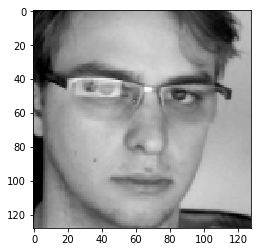

In [7]:
idx = 0
plt.imshow(images[idx], cmap="gray")
print("\t\t"+str(labels[idx]))

In [8]:
import random
def balanced_subset(images,labels):
    #np.warnings.filterwarnings('ignore')
    count = Counter(labels)
    perclass_count = np.array([[c,count[c]] for c in count.keys()])
    max_n = min(perclass_count[:,1])
    
    perclass_indexes = {cname:random.sample(range(0, n), max_n) for cname,n in perclass_count}
    perclass_index = {label:0 for label in count.keys()}
    
    newlabels = []
    newimages = []
    total = 0
    for i in range(len(labels)):
        
        label = labels[i]

        if perclass_index[label] in perclass_indexes[label]:
            total += 1
            newlabels.append(label)
            newimages.append(images[i])
        perclass_index[label] += 1
            
    newimages, newlabels = np.array(newimages),np.array(newlabels)   
        
    #print(perclass_count,perclass_indexes)
    return newimages, newlabels

In [9]:
from collections import Counter
labels = [x.lower() for x in labels]
count = Counter(labels)
#print(c.most_common())
label2int = {y:x for x,(y,_) in enumerate(count.most_common())}

nplabels = np.array([label2int[x] for x in labels])
assert(len(nplabels) == len(images))
print("count:",count.most_common(),"\n")




count: [('happy', 40), ('sad', 40), ('angry', 40), ('neutral', 39)] 



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train, x_val, y_train, y_val = train_test_split(images, nplabels, test_size=.01)
len(y_val)

2

In [11]:
def next_batch(images, labels, batch_size):
    for i in range(0,len(labels),batch_size):
        if i+batch_size >= len(labels):
            yield images[i:],labels[i:]
        else:
            yield images[i:i+batch_size],labels[i:i+batch_size]

In [12]:
print(images[0].shape)

(128, 128)


# Build Model

In [13]:
import tensorflow as tf

In [14]:
num_classes = len(count.most_common())
x = tf.placeholder(dtype=tf.float32, shape=(None,128,128),name='x')
y = tf.placeholder(dtype=tf.uint8, shape=(None),name="y")
lr = tf.placeholder(dtype=tf.float32, shape=[], name="lr")

In [15]:
one_hot = tf.one_hot(y,num_classes)
reshaped = tf.expand_dims(x,-1)

In [16]:
#batch,128,128,1

#first convolution
conv = tf.contrib.layers.conv2d(
    reshaped,
    32,
    (9,9),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,120,120,32

#subsample
pool = tf.contrib.layers.max_pool2d(
    conv,
    (4,4),
    stride=(4,4))
#batch,30,30,32

#second convolution
conv2 = tf.contrib.layers.conv2d(
    pool,
    64,
    (11,11),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,20,20,64

#subsample
pool2 = tf.contrib.layers.max_pool2d(
    conv2,
    (4,4),
    stride=(4,4))
#batch,5,5,64

#flatten
flat = tf.contrib.layers.flatten(pool2)
#batch,1600

#fully connected
fc = tf.contrib.layers.fully_connected(
    flat,
    256,
    activation_fn=tf.nn.relu,
    weights_initializer=tf.initializers.random_normal)
#batch,256
logits = tf.contrib.layers.fully_connected(
    fc,
    num_classes,
    weights_initializer=tf.initializers.random_normal)

prediction = tf.nn.softmax(logits,)

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot)
loss_op = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(lr).minimize(loss_op)
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(one_hot,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [20]:
epochs = 40
learn_rate = .0001
batch_size = 8

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch in range(epochs):
        batch_i = 1
        #for X,Y in next_batch(x_train,y_train,batch_size):
        X,Y = balanced_subset(images,nplabels)
        X,Y = shuffle(X,Y)
        
        for i in range(10):
            sess.run(optimizer,feed_dict={x:X,y:Y,lr:learn_rate})
            if batch_i % 10 == 0:
                valacc = sess.run(accuracy,feed_dict={x:x_val,y:y_val})
                loss, trainacc = sess.run([loss_op, accuracy], feed_dict={x:X,y:Y})
                print("epoch {} \tbatch: {}\ttrain accuracy: {}\tloss: {}\tval acc: {}"
                      .format(epoch,batch_i,round(float(trainacc),4),round(float(loss),4), round(float(valacc),4)))               
                
            batch_i += 1
    X,Y = balanced_subset(images,nplabels)
    X,Y = shuffle(X,Y)
    print(sess.run(prediction,feed_dict={x:X,y:Y,lr:learn_rate}))
    save_path = saver.save(sess, "checkpoints/model.ckpt")

            

epoch 0 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 1 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 2 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 3 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 4 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 5 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 6 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 7 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 8 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 9 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 10 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 11 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 12 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 13 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch 14 	batch: 10	train accuracy: 0.25	loss: 1.3863	val acc: 0.0
epoch

In [ ]:
batch_i = np.array(0)
trainacc = np.array(0.238473172372)
loss = np.array(12314.52365646352)

In [34]:
print("batch: {}\ttrain accuracy: {}\tloss: {}"
                      .format(batch_i,round(trainacc,4),round(loss,4)))

TypeError: type numpy.ndarray doesn't define __round__ method

In [28]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "checkpoints/model.ckpt")
    sess.run()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
